### 1. Import Dependencies and Data

In [2]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 511.7 MB 4.3 kB/s 
     |████████████████████████████████| 497.9 MB 16 kB/s 


In [1]:
#limit memory usage(we'r not gonna blow out of RAM while building deep NN)

import tensorflow as tf
# grab all GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
#tfds for Fashion MNIST dataset
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
#use the tensorflow datasets api to bring in data source
ds = tfds.load('fashion_mnist',split='train')

#doing this,we haven't loaded our images in memory
#it's a pipeline to which there will set of repeatable calls to bring in data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFT4A6U/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFT4A6U/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [5]:
#we need an iterator to bring back the data
#by calling next we bring the next batch of data
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.Viz Data and Build Dataset

In [7]:
#Do some data transformation
import numpy as np

In [8]:
#Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()


In [9]:
#getting data out of pipeline
dataiterator.next() #this just brings back  new data everytime and saves memory
print(dataiterator.next()['image'].shape)

(28, 28, 1)


In [10]:
#we want to remove 3rd dimension
np.squeeze(dataiterator.next()['image']).shape


(28, 28)

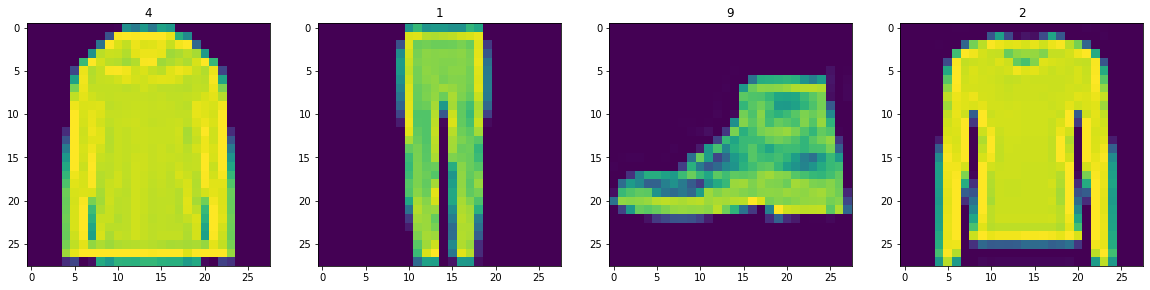

In [11]:
#setup the subplot formatting
#we say that we want total fig of 20X20 with 4 figs in it
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
#loop 4 times and get images
for idx in range(4):

  #grab an image and label
  sample = dataiterator.next()

  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [12]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d9ca8f890>,
      dtype=object)

In [13]:
#right now we are not doing supervised learning
#so labels are not needed
#if we have been doing conditional GAN where we had to decide what images we wanted then we had to use labels

#Scale and return images only
def scale_images(data):
  image = data['image']
  return image/255

Steps to follow while building a tensorflow pipeline

1.map

2.cache

3.shuffle

4.batch

5.prefetch

In [14]:
#Reload the dataset
ds = tfds.load('fashion_mnist',split='train')

#Running the dataset through the sca;e_images preprocessing step
ds = ds.map(scale_images)

#Cache the dataset for that batch
ds = ds.cache()

#Shuffle it up
ds = ds.shuffle(60000)

#Batch into 128 images per sample
ds = ds.batch(128)

#Reduces likelihood of bottlenacking
ds = ds.prefetch(64)


In [15]:
ds.as_numpy_iterator().next().shape
#now we have a batch of 128 images

(128, 28, 28, 1)

### 3. Build Neural Network

3.1 Modelling components

In [16]:
#the generator is gonna take some random/latent values and generate image
#the discriminator is gonna take the generated and real images and provide binary classification result if they are same or not

#Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential

#Bring in the layers for neural network
#UpSampling2D will be used by generator to add more space to image being generated
from tensorflow.keras.layers import Conv2D, Dense,Flatten, Reshape, LeakyReLU,Dropout,UpSampling2D

In [20]:
def build_generator():
  model = Sequential()

  # take 128 random values as input
  #converting 128 length array to 128 no of 7*7 size images
  model.add(Dense(7*7*128,input_dim=128))
  
  #activation to cater for non-linarities in out model
  model.add(LeakyReLU(0.2))

  #finally reshape
  model.add(Reshape((7,7,128)))

  #starting from 7*7*128 we will progress to 28*28*1(eq to dimesnion of images to generate)


  #upsampling block 1
  model.add(UpSampling2D())
  #now OP img size:14*14*128
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))
  #now OP img size:14*14*128

  #upsampling block 2
  model.add(UpSampling2D())
  #now OP img size:28*28*128
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))
  #now OP img size:28*28*128

  #conv layers to add more params to learn well about img to generate
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))
  #now OP img size:28*28*128

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))
  #now OP img size:28*28*128

  #Conv layer to get to 1 channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))
  #now OP img size:28*28*1

  return model

In [21]:
test_model = build_generator()

In [22]:
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [24]:
img = test_model.predict(np.random.randn(4,128,1))
#generating 4 different random images here
img

array([[[[0.5012147 ],
         [0.50121766],
         [0.49924713],
         ...,
         [0.49810758],
         [0.50104046],
         [0.5014029 ]],

        [[0.4998549 ],
         [0.5001626 ],
         [0.5004141 ],
         ...,
         [0.49699795],
         [0.5006222 ],
         [0.5019035 ]],

        [[0.49448594],
         [0.49394682],
         [0.4926598 ],
         ...,
         [0.4946602 ],
         [0.5013672 ],
         [0.5016376 ]],

        ...,

        [[0.5046289 ],
         [0.50372136],
         [0.5070985 ],
         ...,
         [0.49442148],
         [0.4975604 ],
         [0.4985907 ]],

        [[0.50002384],
         [0.49995333],
         [0.50001407],
         ...,
         [0.49463508],
         [0.50191635],
         [0.5001169 ]],

        [[0.4994337 ],
         [0.4969735 ],
         [0.49885193],
         ...,
         [0.49852082],
         [0.5038691 ],
         [0.50137156]]],


       [[[0.5041635 ],
         [0.49950114],
         [0.49

In [25]:
img.shape

(4, 28, 28, 1)

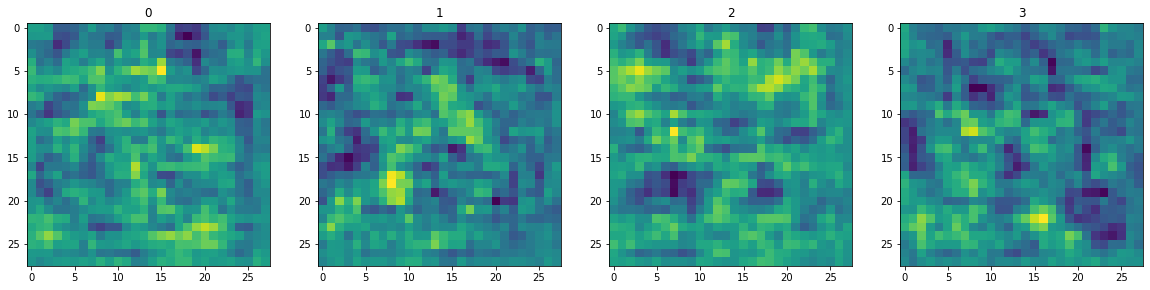

In [26]:
#setup the subplot formatting
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
#loop 4 times and get images
for idx,img in enumerate(img):
  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

Discriminator is just an image classifier if it's fake or not
with just some Dropout layers added to increase regularisation;
so we want it a bit difficult for discriminator to learn so that it does not completely outshine the generator(hardest part in GAN)

In [34]:
def build_discrimintor():
  model = Sequential()

  #1st conv block
  #passing 28*28*1 fake generated image as input
  model.add(Conv2D(32,5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #2nd conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #3rd conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #4th conv block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))



  return model

In [35]:
disc = build_discrimintor()

In [43]:
disc.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [37]:
#Neural network first expects a batch size of images
disc.predict(np.expand_dims(img,0)) #for 1 img

array([[0.51608187]], dtype=float32)

In [38]:
#for a batch of images
img = test_model.predict(np.random.randn(4,128,1))
disc.predict(img)

array([[0.51606244],
       [0.51596683],
       [0.5161143 ],
       [0.5160569 ]], dtype=float32)

### 4.Custom Training Loop

Training of GANs is notoriously difficult bcz there is a balance needed netween the spped of learning of gen and disc

One way is to add some random noise to OP of disc to trick it and make it learn a little slow

It trains pretty good amount of time

We cant just use model.fit() as gen and disc have to be trianed side by side

4.1 Setup Losses and Optimisers

In [39]:
#Adam is going to be the optimiser for both
from tensorflow.keras.optimizers import Adam

#Binary cross entropy is going to be loss for both
#for gen as generated img will be given to disc and it will give feedback if img produced looks real or not
#disc and gen are rewarded for tricking each other
from tensorflow.keras.losses import BinaryCrossentropy

While building Super Resolution GAN our model has to actually use a combination of different types of loss functions

MSE is used for perceptual loss and that is how actual img resolution and created img resolution are highly diff

In [40]:
#Keeping learning rate of gen fast
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

In [41]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [42]:
#Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [54]:
class FashionGAN(Model):
  #args and keywordargs help in using any of the base class' functionality
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)

    #Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    #Compile with base class
    super().compile(*args,**kwargs)

    #Create attributes for losses and optimisers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self,batch):

    #Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)
    #right now Deep gen is not being trained

    #Train the disc
    #for this we have to start calculating teh gradients
    with tf.GradientTape() as d_tape:

      #Pass the real and fake imgs to disc model
      #training True means Dropout will be done
      yhat_real = self.discriminator(real_images,training=True)
      yhat_fake = self.discriminator(fake_images,training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)
    
      #Create labels for real and fake imgs
      #0 for real and 1 for fake
      #outputs a matrix of onlys 0s ot 1s of size same as of image
      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

      #Add some noise to true outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)
    
      #Calculate loss = BCE
      total_d_loss = self.d_loss(y_realfake,yhat_realfake)

    #Apply backpropagation -- nn learn
    #calculate gradient wrt to loss
    dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    #look at the gradients at each of the variables and apply back prop
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

    #Train the generator
    with tf.GradientTape() as g_tape:
      #Generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

      #Create the predicted labels
      #passing generated imgs through disc(which is not learning at this moment)
      predicted_labels = self.discriminator(gen_images,training=False)

      #Calculate loss - trick to training to fake out the disc
      #We'r actually implying that our generated images are actually real images.
      #So we reward our generator for faking out the discriinator
      #i.e. if the discriminator predicts that a generated image is real
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

    #Apply backprop
    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))
  
    return {"d_loss":total_d_loss,"g_loss":total_g_loss}

In [55]:
#Create instance of subclassed model
fashgan = FashionGAN(test_model,disc)

In [56]:
#Compile the model
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

4.3 Build Callback

In [57]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [68]:
#this will help us save ex of training imgs
class ModelMonitor(Callback):
  #no of images needed to generate & how big our latent dimension should be
  def __init__(self,num_img=3,latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.savefig(f'test{i}.png')
      # img.save(os.path.join('images',f'generated_img{epoch}_{i}.png'))

In [65]:

from google.colab import drive
drive.mount('/content/gdrive')
!cp -r  /content/gdrive/My Drive/ganimgs

Mounted at /content/gdrive


4.4 Train


In [70]:
#Recommended 2000 epochs
#Callbacks is optional
hist = fashgan.fit(ds,epochs=5)
# hist = fashgan.fit(ds,epochs=5,callbacks=[ModelMonitor()])

Epoch 1/5
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2743 - g_loss: 6.1356
Epoch 2/5
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2729 - g_loss: 5.6697
Epoch 3/5
469/469 [==============================] - 74s 158ms/step - d_loss: 0.3846 - g_loss: 3.3178
Epoch 4/5
469/469 [==============================] - 74s 158ms/step - d_loss: 0.5808 - g_loss: 0.6380
Epoch 5/5
469/469 [==============================] - 74s 157ms/step - d_loss: 0.3547 - g_loss: 1.7663


In [71]:
hist = fashgan.fit(ds,epochs=15)

Epoch 1/15
469/469 [==============================] - 75s 161ms/step - d_loss: 0.3921 - g_loss: 0.2572
Epoch 2/15
469/469 [==============================] - 75s 159ms/step - d_loss: 0.3857 - g_loss: 0.2329
Epoch 3/15
469/469 [==============================] - 75s 159ms/step - d_loss: 0.3351 - g_loss: 0.0772
Epoch 4/15
469/469 [==============================] - 75s 159ms/step - d_loss: 0.7330 - g_loss: 0.5374
Epoch 5/15
469/469 [==============================] - 74s 158ms/step - d_loss: 0.7005 - g_loss: 0.6582
Epoch 6/15
469/469 [==============================] - 75s 159ms/step - d_loss: 0.6930 - g_loss: 0.6496
Epoch 7/15
469/469 [==============================] - 74s 158ms/step - d_loss: 0.6920 - g_loss: 0.6379
Epoch 8/15
469/469 [==============================] - 74s 159ms/step - d_loss: 0.6853 - g_loss: 0.6477
Epoch 9/15
469/469 [==============================] - 75s 159ms/step - d_loss: 0.6922 - g_loss: 0.6523
Epoch 10/15
469/469 [==============================] - 74s 159ms/step - d

In [72]:
hist.history

{'d_loss': [0.34721794724464417,
  0.33176857233047485,
  0.35324838757514954,
  0.7004562020301819,
  0.6938648223876953,
  0.723291277885437,
  0.6940861940383911,
  0.7050618529319763,
  0.6920132637023926,
  0.7247454524040222,
  0.6774587631225586,
  0.6787248849868774,
  0.7060436606407166,
  0.6576042771339417,
  0.561276376247406],
 'g_loss': [0.23045270144939423,
  0.0738934651017189,
  0.09650242328643799,
  0.6562094688415527,
  0.684252142906189,
  0.5694763660430908,
  0.5982611179351807,
  0.569016695022583,
  0.6835558414459229,
  0.593962550163269,
  0.650323212146759,
  0.6606823205947876,
  0.6006225347518921,
  0.6440722942352295,
  0.8218918442726135]}

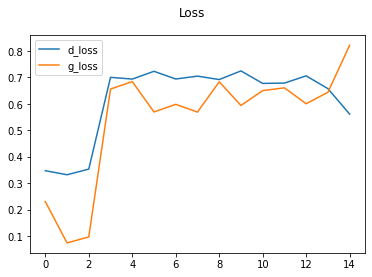

In [74]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend()
plt.show()

### 5.Test Out the Generator

5.1 Generate Images

In [80]:
imgs = test_model.predict(tf.random.normal((16,128,1)))
imgs.shape

(16, 28, 28, 1)

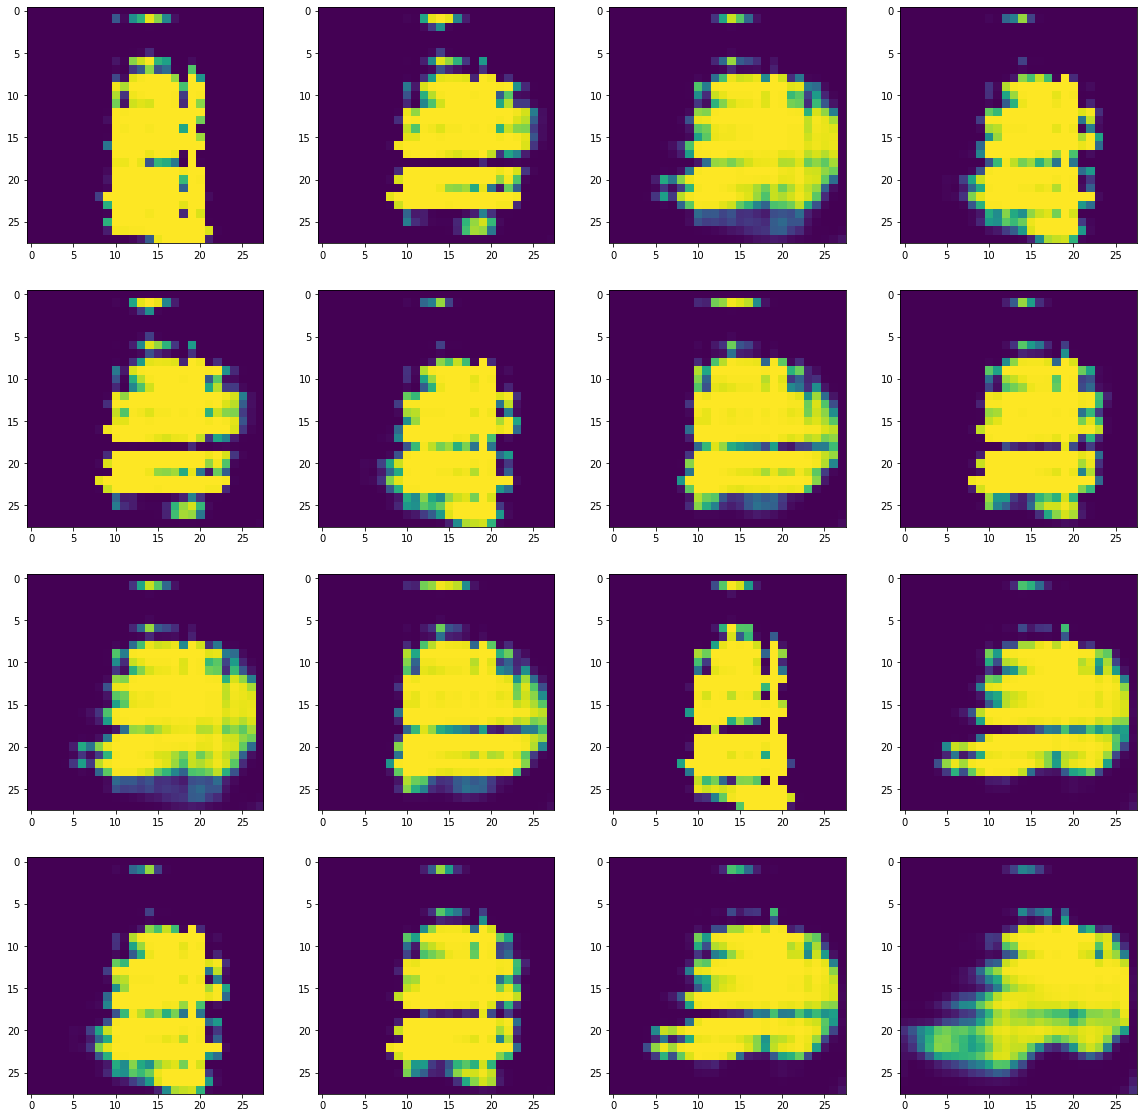

In [78]:
fig,ax = plt.subplots(ncols=4,nrows=4,figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(np.squeeze(imgs[(r+1)*(c+1)-1]))

In [79]:
hist = fashgan.fit(ds,epochs=25)

Epoch 1/25
469/469 [==============================] - 71s 150ms/step - d_loss: 0.6904 - g_loss: 0.6321
Epoch 2/25
469/469 [==============================] - 74s 158ms/step - d_loss: 0.6933 - g_loss: 0.6347
Epoch 3/25
469/469 [==============================] - 74s 159ms/step - d_loss: 0.6845 - g_loss: 0.6278
Epoch 4/25
469/469 [==============================] - 74s 158ms/step - d_loss: 0.6518 - g_loss: 0.6302
Epoch 5/25
469/469 [==============================] - 74s 158ms/step - d_loss: 0.4719 - g_loss: 1.6990
Epoch 6/25
469/469 [==============================] - 74s 159ms/step - d_loss: 0.4755 - g_loss: 0.4319
Epoch 7/25
469/469 [==============================] - 74s 158ms/step - d_loss: 0.6971 - g_loss: 0.5542
Epoch 8/25
469/469 [==============================] - 74s 159ms/step - d_loss: 0.6803 - g_loss: 0.6036
Epoch 9/25
469/469 [==============================] - 74s 158ms/step - d_loss: 0.6911 - g_loss: 0.6017
Epoch 10/25
469/469 [==============================] - 74s 159ms/step - d

In [81]:
hist.history

{'d_loss': [0.5830994248390198,
  0.6926504373550415,
  0.7448139786720276,
  0.6220505833625793,
  0.3953135907649994,
  0.8609724044799805,
  0.6954459547996521,
  0.6986603736877441,
  0.6880155205726624,
  0.6503737568855286,
  0.6837086081504822,
  0.7153355479240417,
  0.7136531472206116,
  0.6971551179885864,
  0.6844528913497925,
  0.7053273320198059,
  0.6860336661338806,
  0.6933141946792603,
  0.7079950571060181,
  0.7074592709541321,
  0.6992411017417908,
  0.7206485867500305,
  0.7909782528877258,
  0.7160449028015137,
  0.7272123694419861],
 'g_loss': [0.665317952632904,
  0.5852140188217163,
  0.6169487237930298,
  0.5118839144706726,
  2.538837432861328,
  0.4129980206489563,
  0.5779540538787842,
  0.610292911529541,
  0.66131591796875,
  0.6799209117889404,
  0.5832974910736084,
  0.6307998895645142,
  0.6159351468086243,
  0.6231606006622314,
  0.5808969736099243,
  0.6304687857627869,
  0.6777782440185547,
  0.6477401852607727,
  0.5542056560516357,
  0.621542453765

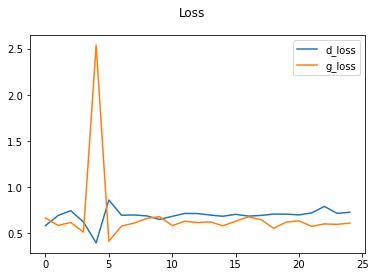

In [82]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend()
plt.show()

In [83]:
imgs = test_model.predict(tf.random.normal((16,128,1)))
imgs.shape

(16, 28, 28, 1)

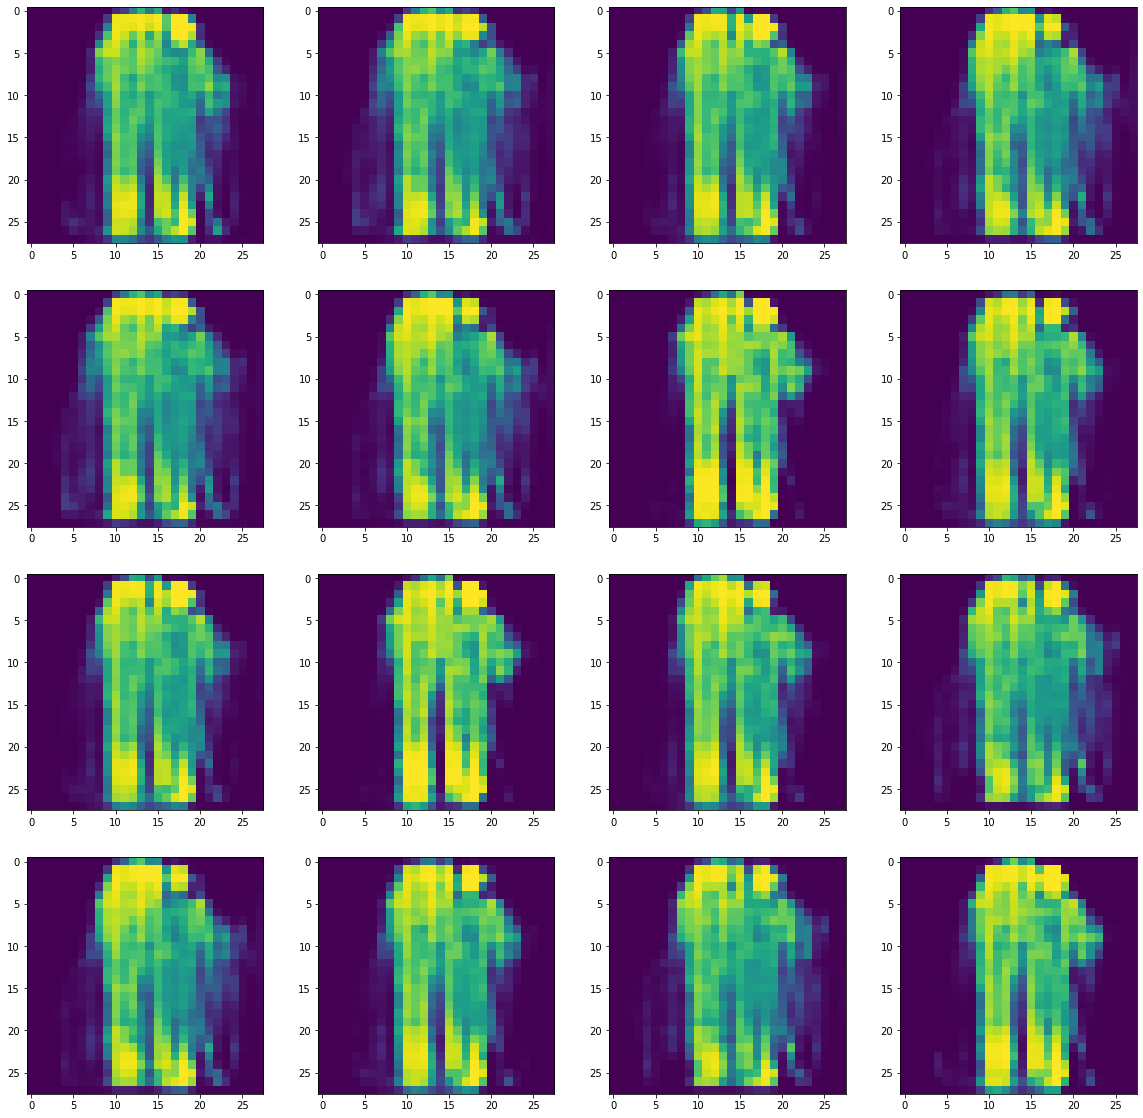

In [84]:
fig,ax = plt.subplots(ncols=4,nrows=4,figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(np.squeeze(imgs[(r+1)*(c+1)-1]))

5.2 Save the Model

In [85]:
test_model.save('generator.h5')
disc.save('discriminator.h5')